# Plot Simulation Result of Fault-Tolerant Control of a Quadrotor

In [1]:
# numpy-quaternion required  
# Cf. https://quaternion.readthedocs.io/en/latest/
# Run the following command to install numpy-quaternion
# %pip install numpy-quaternion

In [2]:
import os
import math
import numpy as np
import quaternion as qt
import matplotlib.pyplot as plt

### Definition of Class and Function

In [3]:
# ResponseCharacteristics class and respinfo function
class ResponseCharacteristics:
    def __init__(self, SteadyStateValue, SteadyStateError, Overshoot, SettlingTime, RiseTime, DelayTime, PeakTime, UnderShoot):
        self.SteadyStateValue = SteadyStateValue
        self.SteadyStateError = SteadyStateError
        self.Overshoot  = Overshoot
        self.SettlingTime = SettlingTime
        self.RiseTime   = RiseTime
        self.DelayTime  = DelayTime
        self.PeakTime   = PeakTime
        self.UnderShoot = UnderShoot

    def disp(self):
        for key, value in self.__dict__.items():
            print(key, ':', value)


def respinfo(T,Y,yref=0.0,SettlingTimeThreshold=0.02,SteadyStateRatio=0.2):
    yfinal = np.mean(Y[-math.ceil(SteadyStateRatio*Y.shape[0]):-1])  # mean value of the last (100*SteadyStateRatio) % data 
    yfinalerror = yfinal - yref
    ydifference = yfinal - Y[0]
    if ydifference == 0:
        print('*** Warning: Initial and final values are identical. ***')
        print('Overshoot, settling time, rise time, and undershoot are set to be zero. ')
        return ResponseCharacteristics(yfinal, yfinalerror, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    if ydifference < 0:
        print('*** Warning: Final value is smaller than the initial value. ***')
        ypeak = np.min(Y)
        peaktime = T[np.argmin(Y)]
    else:
        ypeak = np.max(Y)
        peaktime = T[np.argmax(Y)]
    overshoot = 100 * (ypeak - yfinal) / ydifference  # percent
    settlingthreshold = SettlingTimeThreshold * abs(ydifference)
    ysettling_upper = yfinal + settlingthreshold
    ysettling_lower = yfinal - settlingthreshold
    tuple_settling = np.where((Y > ysettling_upper) | (Y < ysettling_lower))
    ind_settling = np.max(tuple_settling)
    settlingtime = T[ind_settling]
    if settlingtime == T[-1]:
        print('*** Warning: Response does not settle by the end. ***')
        print('Steady state value and settling time are given by the final value and final time, respectively. ')
        print('Overshoot is set to be zero. ')
        yfinal = Y[-1]
        yfinalerror = yfinal - Y[0]
        overshoot = 0
    yrise_lower = Y[0] + 0.1 * ydifference
    yrise_upper = Y[0] + 0.9 * ydifference
    ydelay = 0.5*(yfinal+Y[0])
    if ydifference > 0:
        ind_rise_lower = np.min(np.where(Y >= yrise_lower))
        ind_rise_upper = np.min(np.where(Y >= yrise_upper))
        ind_delay = np.min(np.where(Y >= ydelay))
        ybottom = np.min(Y)
    else:
        ind_rise_lower = np.min(np.where(Y <= yrise_lower))
        ind_rise_upper = np.min(np.where(Y <= yrise_upper))
        ind_delay = np.min(np.where(Y <= ydelay))
        ybottom = np.max(Y)
    risetime = T[ind_rise_upper] - T[ind_rise_lower] 
    delaytime = T[ind_delay]
    undershoot = 100 * (Y[0] - ybottom) / ydifference  # percent
    return ResponseCharacteristics(yfinal, yfinalerror, overshoot, settlingtime, risetime, delaytime, peaktime, undershoot)

## Data Loading

In [4]:
ocp_name = 'QuadrotorFTC'  # Name of OCP

# For Simulation Data in the Default Directory by Jupyter Notebook
#gendir = 'generated'
#fpath = os.path.join(gendir,ocp_name,'log')

# For Simulation Data in a Specific Directory
gendir = 'Quadrotor_log'
fpath = os.path.join(gendir)

In [5]:
print(fpath)
print(os.listdir(fpath))

Quadrotor_log
['Con00', 'Con01', 'Con02', 'Con03', 'Con04', 'FTC00', 'FTC01', 'FTC02', 'FTC03', 'FTC04', 'FTC05', 'FTC06', 'FTC07', 'FTC08', 'FTC09', 'FTC10', 'FTC11', 'FTC12', 'FTC13', 'FTC14', 'FTC_mambo_old', 'FTC_old', 'QuadrotorFTC.pdf', 'QuadrotorFTC_opterr.log', 'QuadrotorFTC_pos_att_inp.pdf', 'QuadrotorFTC_t.log', 'QuadrotorFTC_u.log', 'QuadrotorFTC_x.log', 'Unc00', 'Unc01']


In [6]:
fnamet = os.path.join(fpath,ocp_name+'_t.log')
fnamex = os.path.join(fpath,ocp_name+'_x.log')
fnameu = os.path.join(fpath,ocp_name+'_u.log')
fnamee = os.path.join(fpath,ocp_name+'_opterr.log')
print(fnamex)

Quadrotor_log\QuadrotorFTC_x.log


In [7]:
datat = np.loadtxt(fnamet)
datax = np.loadtxt(fnamex)
datau = np.loadtxt(fnameu)
datae = np.loadtxt(fnamee)

In [8]:
datat[0], datat[-1]

(0.0, 9.998999999999898)

In [9]:
print(datax.shape)
print(datau.shape)

(10000, 13)
(10000, 4)


In [10]:
dimx = datax.shape[1]
dimu = datau.shape[1]

## 2D Plots

In [11]:
plotno = dimx+dimu+1
plotnox = math.floor(plotno/3)
plotnoy = math.ceil(plotno/plotnox)

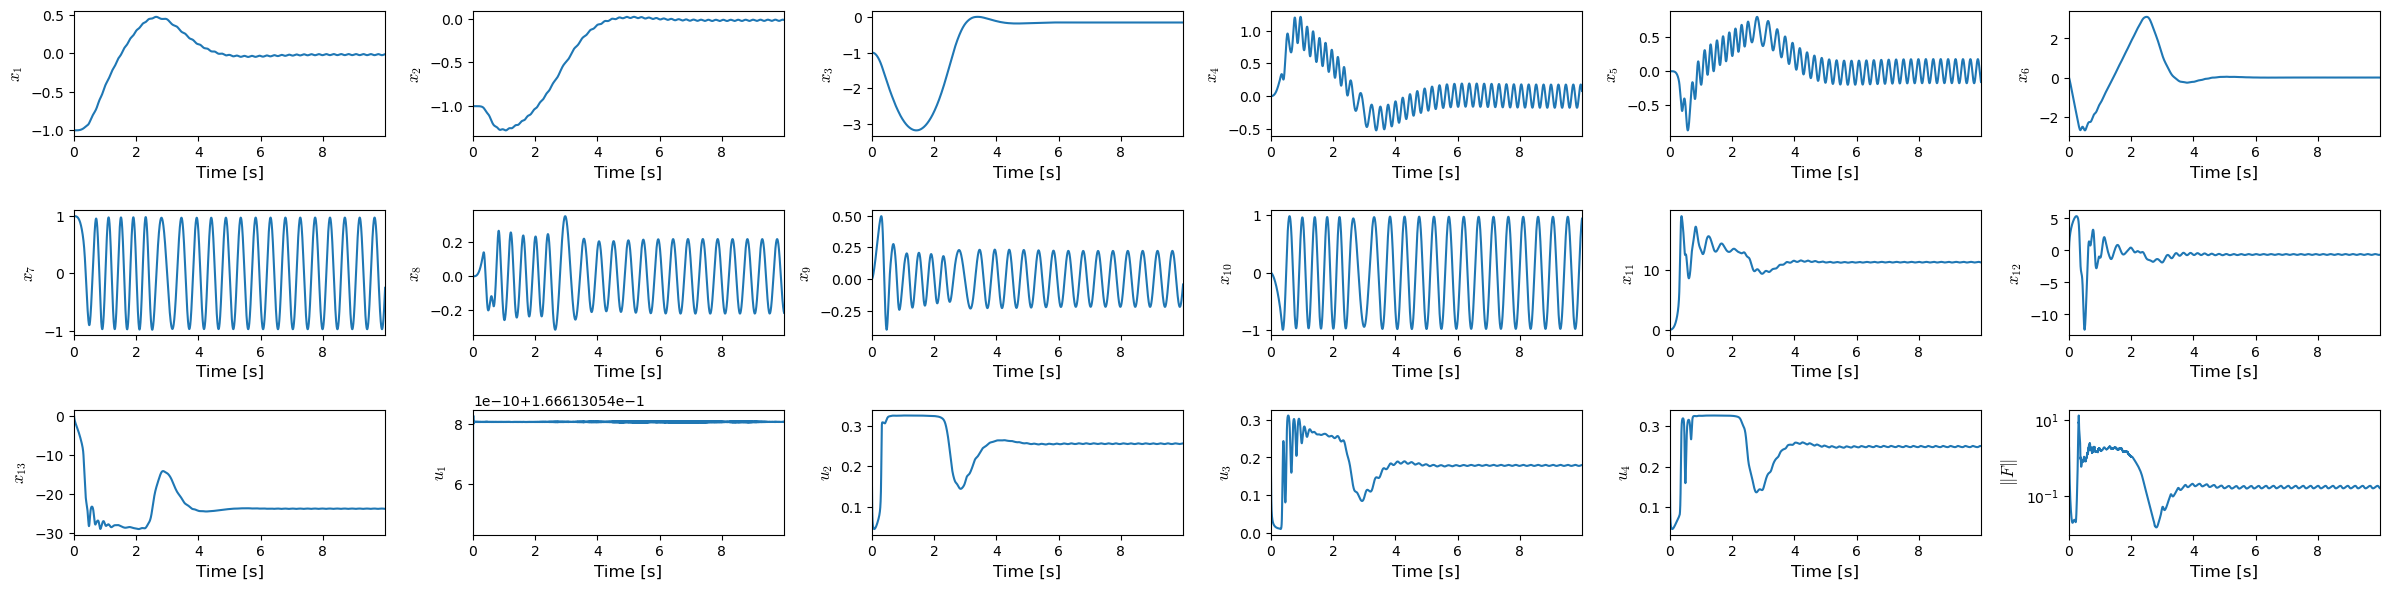

In [12]:
#plt.rcParams['font.family'] = 'Times New Roman'
#plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.subplot.bottom'] = 0.25
plt.figure(tight_layout=True,figsize=(4*plotnox,2*plotnoy))
tmin = min(datat)
tmax = max(datat)
for i in range(dimx):
    ax = plt.subplot(plotnoy,plotnox,i+1,xlabel='Time [s]',ylabel='$x_{'+str(i+1)+'}$',xlim=(tmin,tmax))
    ax.plot(datat,datax[:,i])
for i in range(dimu):
    ax = plt.subplot(plotnoy,plotnox,dimx+i+1,xlabel='Time [s]',ylabel='$u_{'+str(i+1)+'}$',xlim=(tmin,tmax))
    ax.plot(datat,datau[:,i])
ax = plt.subplot(plotnoy,plotnox,plotno,xlabel='Time [s]',ylabel='$\|F\|$',xlim=(tmin,tmax),yscale='log')
ax.plot(datat,datae)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

In [13]:
#print(plt.rcParams)

In [14]:
# Computation of Euler angles
datatmp = []
for q in datax[:,6:10]:
    phi = math.atan2(2*(q[0]*q[1] + q[2]*q[3]),q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2)
    theta = math.asin(-2*(q[1]*q[3] - q[0]*q[2]))
    psi = math.atan2(2*(q[1]*q[2] + q[0]*q[3]),q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
    datatmp.append([phi,theta,psi])

dataeu = np.array(datatmp)

In [15]:
dataeu.shape

(10000, 3)

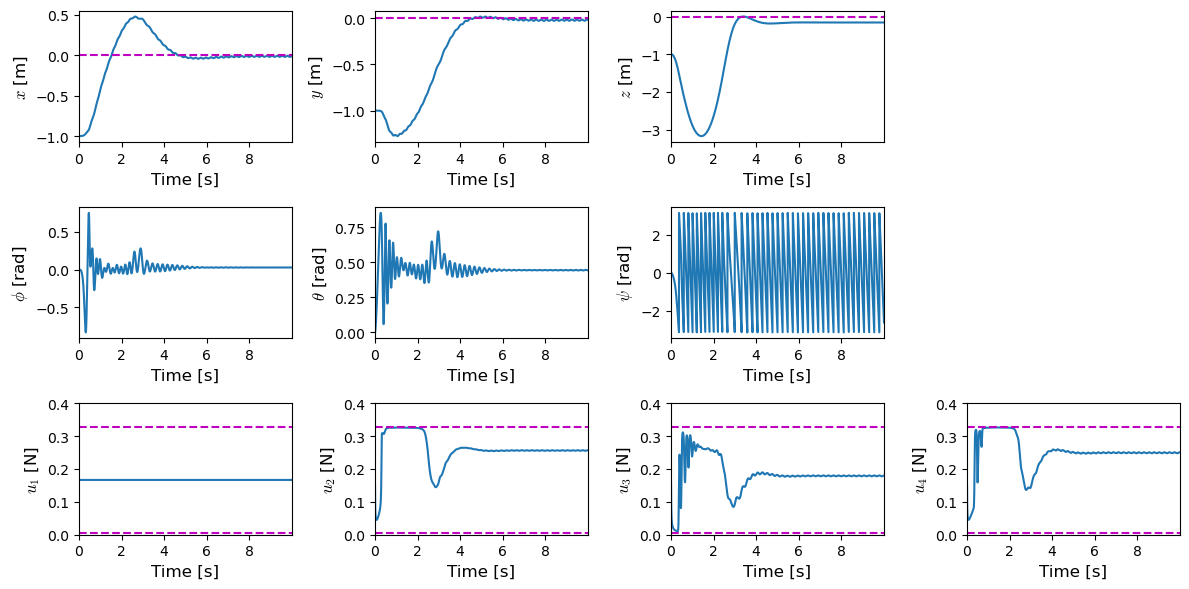

In [16]:
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.subplot.bottom'] = 0.25
plt.figure(tight_layout=True,figsize=(12,6))
tmin = min(datat)
tmax = max(datat)
umin = 0.0065
umax = 0.3266
ulim =(0,0.4)
poslabel = ['$x$ [m]', '$y$ [m]', '$z$ [m]' ]
anglabel = ['$\phi$ [rad]', '$\\theta$ [rad]', '$\psi$ [rad]' ]
inplabel = ['$u_1$ [N]', '$u_2$ [N]', '$u_3$ [N]', '$u_4$ [N]' ]
for i in range(3):
    ax = plt.subplot(3,4,1+i,xlabel='Time [s]',ylabel=poslabel[i],xlim=(tmin,tmax))
    ax.plot(datat,datax[:,i])
    ax.plot([tmin,tmax],[0,0],'m--')
for i in range(3):
    ax = plt.subplot(3,4,5+i,xlabel='Time [s]',ylabel=anglabel[i],xlim=(tmin,tmax))
    ax.plot(datat,dataeu[:,i])
for i in range(4):
    ax = plt.subplot(3,4,9+i,xlabel='Time [s]',ylabel=inplabel[i],xlim=(tmin,tmax),ylim=ulim)
    ax.plot(datat,datau[:,i])
    ax.plot([tmin,tmax],[umax,umax],'m--')
    ax.plot([tmin,tmax],[umin,umin],'m--')
fnamefig = os.path.join(fpath,ocp_name+'_pos_att_inp.pdf')
plt.savefig(fnamefig)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

In [17]:
posvars = ['x(t)', 'y(t)', 'z(t)']
for i in range(3):
    print('----- Characteristics of', posvars[i], '-----')
    respinfo(datat,datax[:,i]).disp()
    print('')

----- Characteristics of x(t) -----
SteadyStateValue : -0.015740571635543463
SteadyStateError : -0.015740571635543463
Overshoot : 49.859505061300126
SettlingTime : 6.347000000000454
RiseTime : 0.87499999999996
DelayTime : 0.9250000000000007
PeakTime : 2.6399999999998203
UnderShoot : 0.0

----- Characteristics of y(t) -----
SteadyStateValue : -0.019949304675814326
SteadyStateError : -0.019949304675814326
Overshoot : 4.030611505578017
SettlingTime : 6.1530000000003895
RiseTime : 1.5729999999998268
DelayTime : 2.9559999999997855
PeakTime : 5.176000000000063
UnderShoot : 28.24442408483475

----- Characteristics of z(t) -----
SteadyStateValue : -0.15794685472122422
SteadyStateError : -0.15794685472122422
Overshoot : 18.817877727362806
SettlingTime : 5.0870000000000335
RiseTime : 0.3159999999999652
DelayTime : 2.7749999999998054
PeakTime : 3.396999999999737
UnderShoot : 258.24362011127664



## 3D Plots

In [18]:
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d, Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from IPython import display 

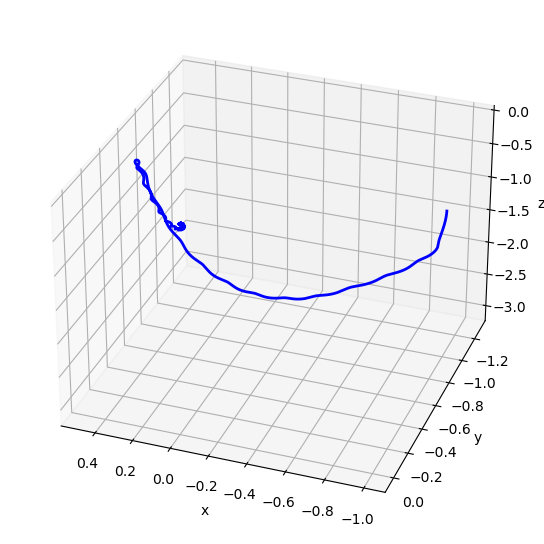

In [19]:
#plt.rcParams['figure.subplot.top'] = 0.9
#plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.right'] = 1
#ax3 = plt.figure(figsize=(6,4), dpi=200).add_subplot(projection='3d')
ax3 = plt.figure(figsize=(6,8)).add_subplot(projection='3d')
#ax3.view_init(elev=20, azim=110)
ax3.view_init(elev=30, azim=110)
ax3.plot(datax[:,0],datax[:,1],datax[:,2], lw=2, c="b")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
#ax3.set_title("Trajectory", size=8)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

In [20]:
def plotquadrotor(ax,t,q):
    l = 0.0624
    line1pos = np.array([[l,0,0],[-l,0,0]])
    line2pos = np.array([[0,l,0],[0,-l,0]])
    qn = qt.from_float_array(q).normalized()
    line1tfm = qt.rotate_vectors(qn,line1pos) + t
    line2tfm = qt.rotate_vectors(qn,line2pos) + t
    line1cordlist = line1tfm.transpose().tolist()
    line2cordlist = line2tfm.transpose().tolist()
    line1 = art3d.Line3D(line1cordlist[0],line1cordlist[1],line1cordlist[2], color='r')
    ax.add_line(line1)
    line2 = art3d.Line3D(line2cordlist[0],line2cordlist[1],line2cordlist[2], color='r')
    ax.add_line(line2)

In [ ]:
fps = 10
intv = math.floor(1000/fps)
sampling_time = datat[1]-datat[0]
dstep = math.floor(intv/sampling_time/1000)
frm = math.floor(datax.shape[0]/dstep)

figa = plt.figure(figsize=(6,6))
axa = figa.add_subplot(projection='3d')
axa.view_init(elev=30, azim=110)

'''
# data-dependent box
xmin,xmax = datax[:,0].min(),datax[:,0].max()
ymin,ymax = datax[:,1].min(),datax[:,1].max()
zmin,zmax = datax[:,2].min(),datax[:,2].max()
'''

# fixed box
xmin,xmax = -1.5,0.5 
ymin,ymax = -1.5,0.5
zmin,zmax = -1.5,0.5

xyzwidth = 0.1 # margin in close-up view

def plotframe(i):
    plt.cla() 
    ind = dstep*i
#    xmin,xmax = datax[ind,0]-xyzwidth,datax[ind,0]+xyzwidth # for close-up view
#    ymin,ymax = datax[ind,1]-xyzwidth,datax[ind,1]+xyzwidth
#    zmin,zmax = datax[ind,2]-xyzwidth,datax[ind,2]+xyzwidth
    axa.set_xlim3d(xmin,xmax)
    axa.set_ylim3d(ymin,ymax)
    axa.set_zlim3d(zmin,zmax)
    axa.set_box_aspect((xmax-xmin,ymax-ymin,zmax-zmin))
    axa.set_xlabel("x")
    axa.set_ylabel("y")
    axa.set_zlabel("z")
    axa.plot(datax[0:ind,0],datax[0:ind,1],datax[0:ind,2],c="b")
#    axa.scatter(datax[ind,0],datax[ind,1],datax[ind,2],c="r")
    plotquadrotor(axa,datax[ind,0:3],datax[ind,6:10])
    axa.set_title('{:>.2f}'.format(sampling_time*ind)+" [sec]", size=8)

ani = animation.FuncAnimation(figa, plotframe, interval=intv, frames=frm)
html = display.HTML(ani.to_jshtml())
display.display(html)
plt.close()
#ani.save("output.gif", writer="pillow")
#plt.show()